In [1]:
import PyHEADTAIL
from PyHEADTAIL.particles import generators
from PyHEADTAIL.general.printers import SilentPrinter
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, ParticleMonitor
from SOLEILII_parameters.SOLEILII_CDR_parameters import *
from PyHEADTAIL.particles import particles
from scipy.constants import m_p
from matplotlib import pyplot as plt
import seaborn as sbs
import numpy as np
N_MACROPARTICLES = int(1e3)
N_TURNS = int(200)
H_RF = 416
N_SEGMENTS = int(25)
np.random.seed(42)
PHI_RF = np.arccos(U_LOSS/V_RF) if (GAMMA**-2-GAMMA_T**-2) < 0 else pi+np.arccos(U_LOSS/V_RF)
PHI_RF = 0
long_map = RFSystems(
    CIRCUMFERENCE,
    [H_RF],
    [V_RF],
    [PHI_RF],
    [ALPHA_0],
    GAMMA,
    mass=m_e,
    charge=e
    )

PyHEADTAIL v1.14.1.63




In [2]:
n_gaps = 50
np.random.seed(42)
#Preparing custom electron bunch train
x_array = np.zeros(shape=(H_RF,))
xp_array = np.zeros(shape=(H_RF,))
y_array = np.zeros(shape=(H_RF,))
yp_array = np.zeros(shape=(H_RF,))
dp_array = np.zeros(shape=(H_RF,))
z_array = np.linspace(0, CIRCUMFERENCE-CIRCUMFERENCE/H_RF, H_RF)

electron_bunch_list = []
monitor_list = []
r_x = 2*np.sqrt(EPSILON_X*BETA_X_SMOOTH)
r_xp = 2*np.sqrt(EPSILON_X*BETA_X_SMOOTH)
r_y = 2*np.sqrt(EPSILON_Y*BETA_Y_SMOOTH)
r_yp = 2*np.sqrt(EPSILON_Y*BETA_Y_SMOOTH)  
for ind, h in enumerate(range(H_RF)):
    np.random.seed(42)
    electron_bunch = generators.ParticleGenerator(macroparticlenumber=N_MACROPARTICLES//2,
                                                  intensity=INTENSITY_PER_BUNCH//2,
                                                  charge=e, gamma=GAMMA, mass=m_e,
                                                  circumference=CIRCUMFERENCE,
                                                  # distribution_x=generators.kv2D(r_x, r_xp),
                                                  distribution_x = generators.gaussian2D(EPSILON_X),
                                                  alpha_x=ALPHA_X_SMOOTH, beta_x=BETA_X_SMOOTH,
                                                  # distribution_y=generators.kv2D(r_y, r_yp),
                                                  distribution_y = generators.gaussian2D(EPSILON_Y),
                                                  alpha_y=ALPHA_Y_SMOOTH, beta_y=BETA_Y_SMOOTH,
                                                  distribution_z=generators.gaussian2D_asymmetrical(SIGMA_Z, SIGMA_DP),
                                                  printer=SilentPrinter()
                                 ).generate()
    electron_bunch_twin = particles.Particles(macroparticlenumber=N_MACROPARTICLES//2,
                                                  particlenumber_per_mp=INTENSITY_PER_BUNCH/N_MACROPARTICLES,
                                                  charge=e, gamma=GAMMA, mass=m_e,
                                                  circumference=CIRCUMFERENCE,
                                                  coords_n_momenta_dict={
                                                    'x': -electron_bunch.x,
                                                    'xp': -electron_bunch.xp,
                                                    'y': -electron_bunch.y,
                                                    'yp': -electron_bunch.yp,
                                                    'z': -electron_bunch.z,
                                                    'dp': -electron_bunch.dp
                                                  },
                                                  printer=SilentPrinter()
                                     )

    electron_bunch += electron_bunch_twin
    np.random.seed(ind)
    electron_bunch.y += np.random.normal(scale=0.02*electron_bunch.sigma_y(), size=1)
    filename = 'Results/BM_n={0:}'.format(int(h))
    bunch_monitor = BunchMonitor(filename, n_steps=N_SEGMENTS*N_TURNS, parameters_dict=None)
    electron_bunch.z += h*CIRCUMFERENCE/H_RF
    electron_bunch_list.append(electron_bunch)
    monitor_list.append(bunch_monitor)
for i in range(n_gaps):
    electron_bunch_list[-i].intensity = 0
    # electron_bunch_list[104+i].intensity = 0
    # electron_bunch_list[208+i].intensity = 0
    # electron_bunch_list[312+i].intensity = 0
print(electron_bunch_list[0].sigma_x())

1.686666556522721e-05


In [3]:
s = np.arange(0, N_SEGMENTS + 1) * CIRCUMFERENCE / N_SEGMENTS
alpha_x, alpha_y = ALPHA_X_SMOOTH * \
    np.ones(N_SEGMENTS), ALPHA_Y_SMOOTH * np.ones(N_SEGMENTS)
beta_x, beta_y = BETA_X_SMOOTH * \
    np.ones(N_SEGMENTS), BETA_Y_SMOOTH * np.ones(N_SEGMENTS)
D_x, D_y = np.zeros(N_SEGMENTS),  np.zeros(N_SEGMENTS)
trans_map = TransverseMap(s, alpha_x, beta_x, D_x,
                              alpha_y, beta_y, D_y, Q_X, Q_Y)

In [4]:
from PyHEADTAIL.ion_cloud.ion_cloud import BeamIonElement
from tqdm.notebook import tqdm
trans_one_turn = [m for m in trans_map]
BI = BeamIonElement()
beam_ion_elements = []
particle_monitor = True
set_aperture = True
n_macroparticles = int(2e5)
n_steps = int(H_RF*N_TURNS)
# for ind, m in enumerate(trans_one_turn):
#     if ind == 0:
#             beam_ion_elements.append(BeamIonElement(dist_ions='GS',
#                                                     monitor_name='Results/IPM(ind={0:})'.format(int(ind)),
#                                                     use_particle_monitor=particle_monitor,
#                                                     set_aperture=set_aperture,
#                                                     n_macroparticles_max=n_macroparticles,
#                                                     n_steps=n_steps,
#                                                     n_segments=N_SEGMENTS,
#                                                     ring_circumference=CIRCUMFERENCE,
#                                                     interaction_model='weak-weak'))
#     beam_ion_elements.append(BeamIonElement(dist_ions='GS',
#                                             monitor_name='Results/IM(ind={0:})'.format(int(ind)),
#                                             set_aperture=set_aperture,
#                                             n_macroparticles_max=n_macroparticles,
#                                             n_steps=n_steps,
#                                             n_segments=N_SEGMENTS,
#                                             ring_circumference=CIRCUMFERENCE,
#                                             interaction_model='weak-weak'))
trans_one_turn = [item for sublist in zip(trans_one_turn, beam_ion_elements) for item in sublist]
print('First 5 elements of a transverse map: ')
for item in trans_one_turn[:5]:
    print(item)
# for turn in tqdm(range(N_TURNS)):
#     for index, m_ in enumerate((trans_one_turn)):
#         for bunch_index, electron_bunch in enumerate(electron_bunch_list):
#             m_.track(electron_bunch_list[bunch_index])    
#             long_map.track(electron_bunch_list[bunch_index])
#             if index % 2 == 0:
#                 monitor_list[bunch_index].dump(electron_bunch_list[bunch_index])
#             if electron_bunch_list[bunch_index].intensity < 1e3 and (index+1) % 2 == 0:
#                 m_.clear_ions()

First 5 elements of a transverse map: 


In [17]:
from PyHEADTAIL.ion_cloud.ion_cloud import BeamIonElement
BI = BeamIonElement(dist_ions='GS',
                    monitor_name=None,
                    set_aperture=set_aperture,
                    n_macroparticles_max=int(1e4),
                    n_steps=n_steps,
                    n_segments=N_SEGMENTS,
                    ring_circumference=CIRCUMFERENCE,
                    interaction_model='weak-weak')

In [18]:
electron_bunch = generators.ParticleGenerator(macroparticlenumber=int(1e7),
                                              intensity=INTENSITY_PER_BUNCH,
                                              charge=e, gamma=GAMMA, mass=m_e,
                                              circumference=CIRCUMFERENCE,
                                              # distribution_x=generators.kv2D(r_x, r_xp),
                                              distribution_x = generators.gaussian2D(EPSILON_X),
                                              alpha_x=ALPHA_X_SMOOTH, beta_x=BETA_X_SMOOTH,
                                              # distribution_y=generators.kv2D(r_y, r_yp),
                                              distribution_y = generators.gaussian2D(EPSILON_Y),
                                              alpha_y=ALPHA_Y_SMOOTH, beta_y=BETA_Y_SMOOTH,
                                              distribution_z=generators.gaussian2D_asymmetrical(SIGMA_Z, SIGMA_DP),
                                              printer=SilentPrinter()
                             ).generate()

In [19]:
%%prun
BI.track(electron_bunch)

         855 function calls (842 primitive calls) in 0.330 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.089    0.015    0.089    0.015 {method 'put' of 'numpy.ndarray' objects}
       10    0.089    0.009    0.089    0.009 {built-in method PyHEADTAIL.cobra_functions.stats.std}
       10    0.081    0.008    0.081    0.008 {method 'take' of 'numpy.ndarray' objects}
       18    0.040    0.002    0.040    0.002 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.025    0.025    0.329    0.329 ion_cloud.py:256(track)
       44    0.001    0.000    0.001    0.000 {method 'copy' of 'numpy.ndarray' objects}
        1    0.001    0.001    0.330    0.330 <string>:1(<module>)
        4    0.001    0.000    0.001    0.000 pmath.py:50(_wofz)
        1    0.000    0.000    0.001    0.001 aperture.py:229(tag_lost_ellipse)
        5    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
        4    0.

In [8]:
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, WakeField
from PyHEADTAIL.particles import slicing

n_wake_slices = 500                                                         ### Number of slices for the wakefield interaction
z_cuts = (-4*electron_bunch.sigma_z(), 4*electron_bunch.sigma_z())          ### Range of the slices
print('Wake slicer range: ({0:.3f}, {1:.3f})'.format(z_cuts[0], z_cuts[1]))
wake_slicer = slicing.UniformBinSlicer(                                     ### Slicer used to separate particles based on their longitudinal positions
    n_slices=n_wake_slices, z_cuts=z_cuts)
length = 1 # Beam pipe length in [m].
rho = 1e-6 # Resistivity in [ohm.m].
radius = 10e-3 # Beam pipe radius in [m].
dt_min = CIRCUMFERENCE/c/n_wake_slices                                                  ### Minimal time step
res_wall = CircularResistiveWall(pipe_radius=radius,                        ### Radius of the accelerator pipe
                                  resistive_wall_length=length,                ### Length of the accelerator pipe
                                  dt_min=dt_min,                            ### Timestep
                                  conductivity=1/rho)                       ### Conductivity of the accelerator pipe 

wake_field = WakeField(wake_slicer, res_wall)

Wake slicer range: (-0.011, 0.011)


In [9]:
%%prun
wake_field.track(electron_bunch)

         209 function calls in 0.639 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.153    0.153    0.211    0.211 wake_kicks.py:209(apply)
        1    0.142    0.142    0.208    0.208 wake_kicks.py:246(apply)
        2    0.122    0.061    0.122    0.061 {method 'take' of 'numpy.ndarray' objects}
        1    0.086    0.086    0.112    0.112 slicing.py:599(compute_sliceset_kwargs)
        2    0.048    0.024    0.048    0.024 {method 'astype' of 'numpy.ndarray' objects}
        2    0.033    0.017    0.033    0.017 {built-in method PyHEADTAIL.cobra_functions.stats.mean_per_slice}
       11    0.026    0.002    0.149    0.014 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.015    0.015    0.063    0.063 pmath.py:216(<lambda>)
        1    0.012    0.012    0.012    0.012 {built-in method PyHEADTAIL.cobra_functions.stats.count_macroparticles_per_slice}
        2    0.00

In [10]:
%%timeit 
electron_bunch.x

32.6 ns ± 1.54 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [11]:
electron_bunch.x.shape

(10000000,)

1.46e-05


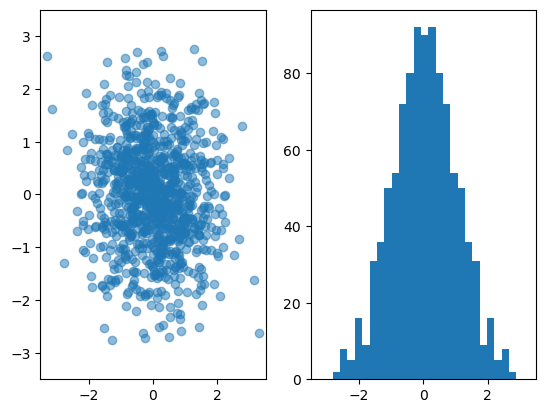

In [12]:
fig, axlist = plt.subplots(1, 2)
axlist[0].scatter(electron_bunch_list[400].x/electron_bunch_list[400].sigma_x(), electron_bunch_list[400].xp/electron_bunch_list[400].sigma_xp(), alpha=0.5) 
# axlist[0].axvline(2*electron_bunch.sigma_x())
# axlist[0].axvline(electron_bunch.sigma_x())
axlist[0].set_ylim(-3.5, 3.5)
print('{:.2e}'.format(electron_bunch_list[0].sigma_y()))
axlist[1].hist(electron_bunch_list[0].y/electron_bunch_list[0].sigma_y(), bins=25)
for ax in axlist:
    ax.set_xlim(-3.5, 3.5)

In [13]:
ion_cloud = trans_one_turn[1].get_ion_beam()
fig, ax = plt.subplots(1, 1)
ax = sbs.jointplot(ion_cloud.y/electron_bunch.sigma_y(), ion_cloud.yp, marker='.', alpha=0.05)
ax.ax_joint.set_xlabel('$y$')
ax.ax_joint.set_ylabel('$p_y$')
ax.ax_joint.set_xlabel('$y_\mathrm{ion}/\sigma_e$')
ax.ax_joint.set_ylim(-10*ion_cloud.sigma_yp(), 10*ion_cloud.sigma_yp())
print('Ion cloud intensity {:.1e}'.format(ion_cloud.intensity))

IndexError: list index out of range

In [ ]:
from scipy.special import k0
fig, ax  = plt.subplots(1, 1)
ion_cloud = trans_one_turn[1].get_ion_beam()
ax = sbs.kdeplot(ion_cloud.y/ion_cloud.sigma_y())
sig = .75
x = np.linspace(-6, 6)
y = 1/np.sqrt(2*pi*sig**2)*np.exp(-x**2/2/sig**2)
ax.plot(x, y)
# r = np.linspace(min(ion_cloud.y), max(ion_cloud.y), 100)
# # ax.plot(r, get_n_i(r, 2*ion_cloud.sigma_y())/2.5e6)
# x = np.linspace(min(ion_cloud.y), max(ion_cloud.y), 100)
# # ax.plot(x, get_dist(x, electron_bunch.sigma_y()))